# Import Packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import os
from os.path import join

import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

from tensorflow.python.compiler.tensorrt import trt_convert as trt

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
# from keras.applications import ResNet50

print(tf.version.VERSION)

2.1.0


In [4]:
#!pip install -q pyyaml h5py

In [5]:
PATH = "../data/DermMel/"
print(os.listdir(PATH))

['valid', '.DS_Store', 'test', 'train', '.ipynb_checkpoints']


In [6]:
PATHtrain = PATH + 'train/'
PATHtest = PATH + 'test/'
PATHvalid = PATH + 'valid/'

# Convoluted Base Model



In [22]:
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

print(conv_base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

> # Model

In [23]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 126,351,234
Trainable params: 126,298,114
Non-trainable params: 53,120
___________________________________

# Make the conv_base NOT Trainable:

In [24]:
for layer in conv_base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


# Compile Frozen conv_base + the Top Layer

In [25]:
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("model compiled")
print(model.summary())

model compiled
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 126,351,234
Trainable params: 102,763,522
Non-trainable params: 23,587,712
________________

# Prep the Train, Valid, and Test directories for the Generator

In [26]:
train_dir = PATHtrain
validation_dir = PATHvalid
test_dir = PATHtest
batch_size = 20
target_size=(224, 224)

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=target_size,batch_size=batch_size)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,target_size=target_size,batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=batch_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


## Print Class Indices

In [27]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}
{'Melanoma': 0, 'NotMelanoma': 1}


# Fit and Generate the Model

In [28]:
# Short training ONLY my top layers 
#... so the conv_base weights will not be destroyed by the random intialization of the new weights


history = model.fit_generator(train_generator,
                              epochs=20,
                              steps_per_epoch = 10682 // batch_size,
                              validation_data = validation_generator,
                              validation_steps = 3562 // batch_size)

Epoch 1/20
534/534 [==============================] - 254s 477ms/step - loss: 1.9238 - accuracy: 0.8782 - val_loss: 11.7455 - val_accuracy: 0.5045
Epoch 2/20
534/534 [==============================] - 247s 462ms/step - loss: 1.4212 - accuracy: 0.9062 - val_loss: 1.5465 - val_accuracy: 0.8954
Epoch 3/20
534/534 [==============================] - 246s 460ms/step - loss: 1.1845 - accuracy: 0.9147 - val_loss: 0.9150 - val_accuracy: 0.9427
Epoch 4/20
534/534 [==============================] - 243s 456ms/step - loss: 1.0005 - accuracy: 0.9207 - val_loss: 0.7850 - val_accuracy: 0.9427
Epoch 5/20
534/534 [==============================] - 244s 457ms/step - loss: 0.8633 - accuracy: 0.9227 - val_loss: 0.7191 - val_accuracy: 0.9401
Epoch 6/20
534/534 [==============================] - 243s 455ms/step - loss: 0.7571 - accuracy: 0.9229 - val_loss: 0.6003 - val_accuracy: 0.9476
Epoch 7/20
534/534 [==============================] - 241s 452ms/step - loss: 0.6686 - accuracy: 0.9242 - val_loss: 0.5611 

# Plot accuracy and validation loss

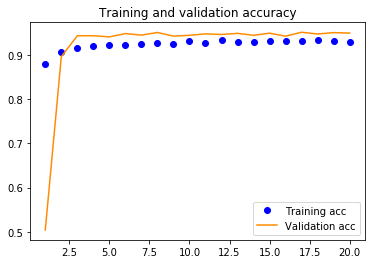

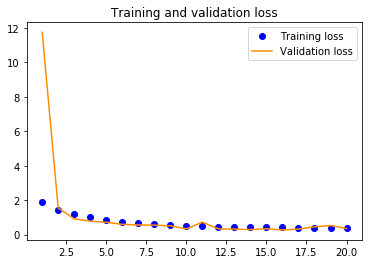

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'darkorange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Save my model

In [47]:
my_model = 'finalized_model.h5'

In [57]:
model.save(filepath = './model.h5')

# Pickle my model

In [ ]:
import pickle
model.fit_generator(X, y) # have to figure out how to properly save this model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [59]:
from tensorflow.keras.models import load_model

In [ ]:
CNN = load_model('model.h5')

In [ ]:
CNN.summary()